In [1]:
%matplotlib inline
import os
from glob import glob

import calendar
import numpy as np
import xarray as xr
import xesmf as xe
import dask
import esmlab

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.path as mpath

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import cmocean
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
#style.use('ggplot')

import util
import shutil

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [2]:
ds_djf = xr.open_zarr('data/cesm-le-fields-djf-epoch-mean2.zarr')
ds_djf

<xarray.Dataset>
Dimensions:    (epoch: 2, length: 4, member_id: 34, nlat: 93, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz         (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * epoch      (epoch) <U9 '1985-2005' '2070-2100'
  * length     (length) float64 20.0 30.0 40.0 50.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * z_t        (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * z_t_150m   (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf   (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    IFRAC      (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    KGP        (epoch, length, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 1, 17, 47, 160), meta=np.ndarray>
    SST        (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>

In [31]:
# Lat Lon Checks
lon = ds_djf.TLONG.values
lat = ds_djf.TLAT.values
# Basic Means
kgp_mean = ds_djf['KGP'].mean('member_id')
sst_mean = ds_djf['SST'].mean('member_id')
chl_mean = ds_djf['Chl_surf'].mean('member_id')
ice_mean = ds_djf['IFRAC'].mean('member_id')

In [4]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

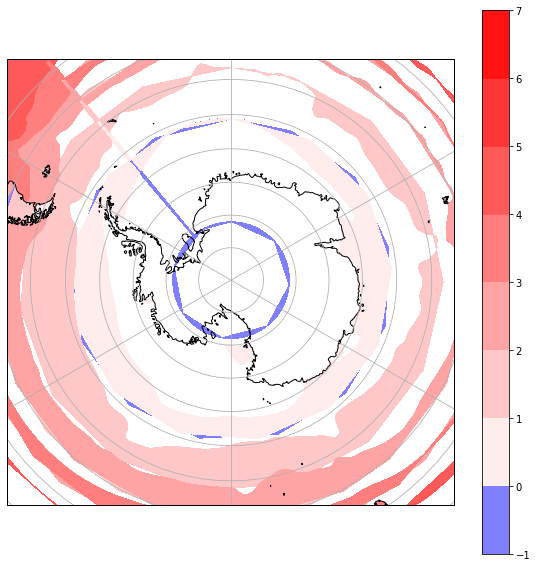

In [11]:
field = sst_mean.sel(epoch = '1985-2005')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -75,  -50], crs=ccrs.PlateCarree())

cf = ax.contourf(lon, lat, field,
                 cmap='bwr', norm=MidpointNormalize(midpoint=0.),
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines().n_steps = 90  ## this makes them rounder

fig.colorbar(cf, ax=ax)

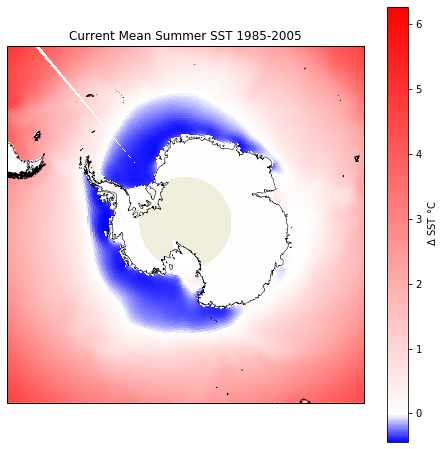

In [12]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Current Mean Summer SST 1985-2005')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, sst_mean.sel(epoch = '1985-2005'), cmap='bwr', norm=MidpointNormalize(midpoint=0.),
                 #vmin = -1, vmax = 6,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label=' $\Delta$ SST °C')
    


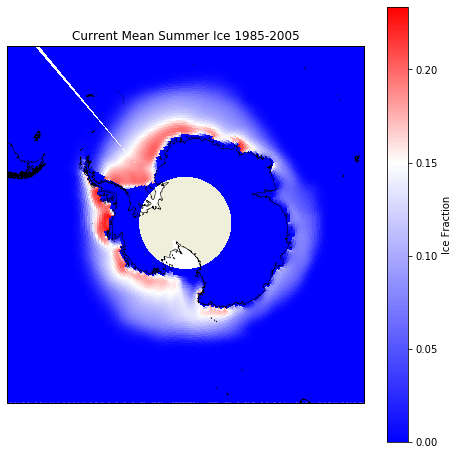

In [16]:
field = ice_mean.sel(epoch = '1985-2005')


fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Current Mean Summer Ice 1985-2005')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, field, cmap='bwr', norm=MidpointNormalize(midpoint=0.15),
                 #vmin = -1, vmax = 6,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Ice Fraction')
    


In [21]:
## Trying to make things look better
test=ds_djf

In [71]:
def compute_kgp(ds, length):
    """Compute Krill Growth Potential 
    
    Natural growth rates in Antarctic krill (Euphausia superba): II. Predictive 
    models based on food, temperature, body length, sex, and maturity 
    stage.[Model 3 (Table 5)]. doi: 10.4319/lo.2006.51.2.0973 
    A Atkinson, RS Shreeve, AG Hirst, P Rothery, GA Tarling 
    Limnol Oceanogr, 2006 
    
    Oceanic circumpolar habitats of Antarctic krill 
    doi: 10.3354/meps07498 
    A Atkinson, V Siegel, EA Pakhomov, P Rothery, V Loeb 
    Mar Ecol Prog Ser, 2008
    
    """
    # specify coefs
    a = -0.066 # Constant - all krill combined (no life stage or sex)
    b = 0.002 # Linear term relating to length
    c = -0.000061 # Quadratic term relating to length
    d = 0.385 # Maximum term relating to food
    e = 0.328 # Half Saturation constant relating to food
    f = 0.0078 # Linear term relating to temperature
    g = -0.0101 # Quadratic term relating to temperature
    
    # local pointers
    sst = ds.SST
    chl = ds.Chl_surf
    ice = ds.IFRAC
            
    # compute terms and sum for: a + b * length + c * length^2 + [d * chl / (e + chl)] + f * SST + g * SST^2 (+ error)
    length_term = a + (b * length) + (c * length**2)
    chl_term = d * chl / (e + chl)    
    sst_term = f * sst + g * sst**2    
    kgp = length_term + chl_term + sst_term
    kgp.name = 'KGP'
    
    # mask based on SST range
    #kgp = kgp.where((-1. <= sst) & (sst <= 5.)).fillna(0.).where(ds.KMT > 0)
    kgp = kgp.where((-1. <= sst) & (sst <= 5.) & (0.15 <= ice)).fillna(0.).where(ds.KMT > 0)

    # add coordinates
    kgp = kgp.assign_coords({'length': length})
    kgp = kgp.assign_coords({'TLONG': ds.TLONG, 'TLAT': ds.TLAT})

    # add attrs
    kgp.attrs = {'units': 'mm d$^{-1}$', 'long_name': 'Daily growth rate'}
    ds['KGP2'] = kgp
    return ds

Define a "length" coordinate.

In [72]:
length = xr.DataArray(
    [20., 30., 40., 50,], 
    name='length',
    dims=('length'), 
    attrs={'units': 'mm', 'long_name': 'Krill body length'})
#length

Perform the actual computation

In [73]:
tested = compute_kgp(test, length)
tested

<xarray.Dataset>
Dimensions:    (epoch: 2, length: 4, member_id: 34, nlat: 93, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz         (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * epoch      (epoch) <U9 '1985-2005' '2070-2100'
  * length     (length) float64 20.0 30.0 40.0 50.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * z_t        (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * z_t_150m   (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf   (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    IFRAC      (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    KGP        (length, epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(4, 1, 9, 47, 160), meta=np.ndarray>
    SST        (epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(1, 9, 47, 160), meta=np.ndarray>
    KGP2       (length, epoch, member_id, nlat, nlon) float64 dask.array<chunksize=(4, 1, 9, 47, 160), meta=np.ndarray>

In [36]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
def plot_examples(colormaps):
    """
    Helper function to plot data with associated colormap.
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)
    n = len(colormaps)
    fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
                            constrained_layout=True, squeeze=False)
    for [ax, cmap] in zip(axs.flat, colormaps):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-1, vmax=5)
        fig.colorbar(psm, ax=ax)
    plt.show()

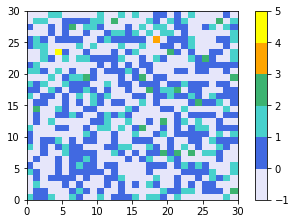

In [55]:
cmap = ListedColormap(["lavender", "royalblue", "mediumturquoise", "mediumseagreen", "orange", "yellow" ], name='murphy')
#cmap = ListedColormap([ "royalblue", "mediumturquoise", "mediumseagreen", "orange" ], name='murphy')
#cmap.set_over('red')
#cmap.set_under('lavender')
plot_examples([cmap])

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


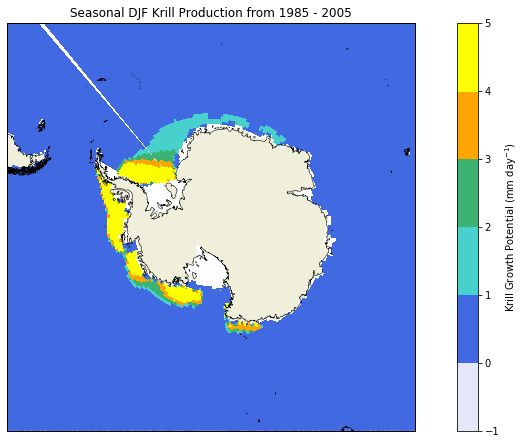

In [62]:
fig = plt.figure(figsize=(15,7.5))

kgp_early = kgp_mean.sel(epoch = '1985-2005').sel(length = '40')
tested

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Seasonal DJF Krill Production from 1985 - 2005')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, kgp_early*30, cmap=cmap,
                 vmin = -1, vmax = 5,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Krill Growth Potential (mm day$^{-1}$)')
#fig.savefig('Seasonal DJF Climatologies from 30 year epochs CESM-LE: 1985-2005', bbox_inches='tight') #,format='pdf');


In [ ]:
fig = plt.figure(figsize=(15,7.5))
kgp_mean2 = tested['KGP'].mean('member_id')
kgp_early = kgp_mean2.sel(epoch = '1985-2005').sel(length = '40')

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Seasonal DJF Krill Production from 1985 - 2005')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, kgp_early*30, cmap=cmap,
                 vmin = -1, vmax = 5,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Krill Growth Potential (mm day$^{-1}$)')
#fig.savefig('Seasonal DJF Climatologies from 30 year epochs CESM-LE: 1985-2005', bbox_inches='tight') #,format='pdf');


<xarray.DataArray 'SST' (epoch: 2, member_id: 34, nlat: 93, nlon: 320)>
dask.array<where, shape=(2, 34, 93, 320), dtype=float64, chunksize=(1, 9, 47, 160), chunktype=numpy.ndarray>
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * epoch      (epoch) <U9 '1985-2005' '2070-2100'
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC

In [27]:
test_mean = test.mean('member_id')


/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


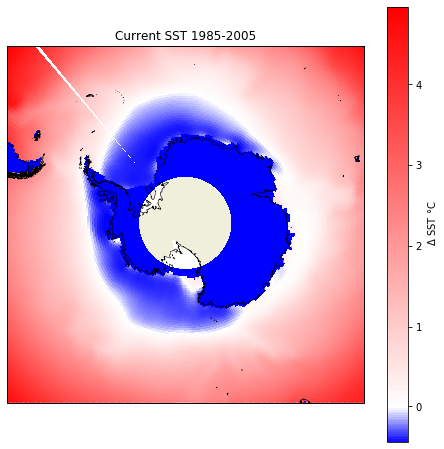

In [30]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Current SST 1985-2005')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, test_mean.sel(epoch = '1985-2005'), cmap='bwr', norm=MidpointNormalize(midpoint=0.),
                 #vmin = -1, vmax = 6,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label=' $\Delta$ SST °C')


In [26]:
test.sel(epoch = '1985-2005')

<xarray.DataArray 'SST' (member_id: 34, nlat: 93, nlon: 320)>
dask.array<getitem, shape=(34, 93, 320), dtype=float64, chunksize=(9, 47, 160), chunktype=numpy.ndarray>
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    epoch      <U9 '1985-2005'
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Dimensions without coordinates: nlat, nlon
Attributes:
    cell_methods:  time: mean
    grid_loc:      3111
    long_name:     Potential Temperature
    units:         degC